In [3]:
# Importing packages
from collections import deque, namedtuple
import time, random
import heapq
import os

# Setting up logger
import logging, importlib

In [4]:
import math
def get_number_of_virtual_links(number_of_nodes: int = 32, max_distance_threshold = 4):
    max_long_link_type = int(math.log(max_distance_threshold, 2))
    return sum([int(number_of_nodes/2 ** x) for x in range(0, max_long_link_type + 1)])

In [16]:
'''
Import the helper functions: map_tuple, mean
'''
%run ./lib/helper.py
%run ./lib/graph.py
%run ./lib/graph_edge_factory.py
%run ./lib/plot.py
%run ./lib/routing_simulation.py
%run ./lib/routing_algorithms.py
%run ./lib/logger.py

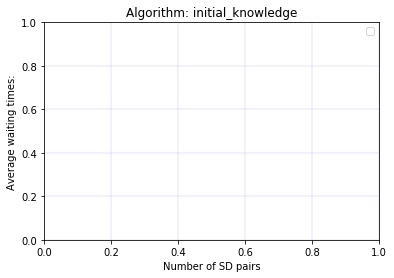

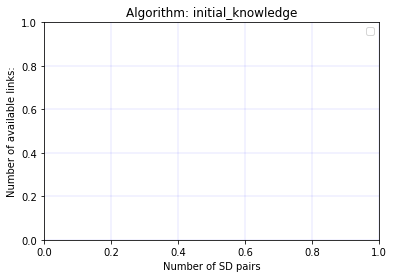

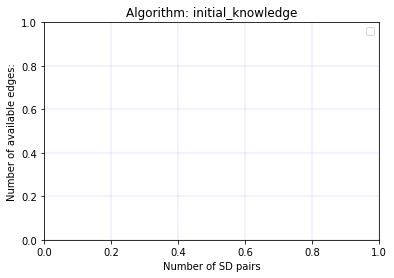

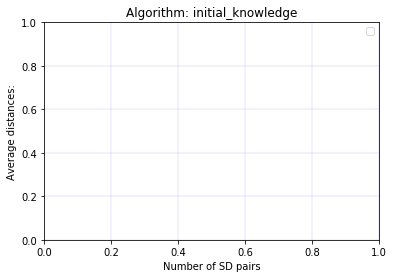

603.9210937023163


In [9]:
arguments = { 'algorithm' : initial_knowledge_init,'graphs': det_graphs}
start = time.time()
initial_knowledge_results = [run_algorithm_for_graphs(Settings().number_of_source_destination_pairs,
                                               Settings().number_of_samples, arguments)]

end = time.time()
plot_results(initial_knowledge_results,'initial_knowledge')
write_results_to_file(initial_knowledge_results, 'initial_knowledge', '' , (end - start))

print(end-start)

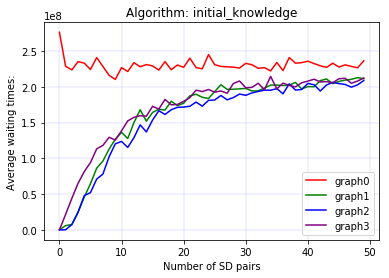

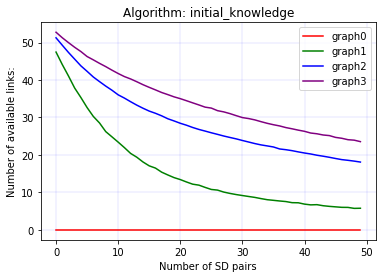

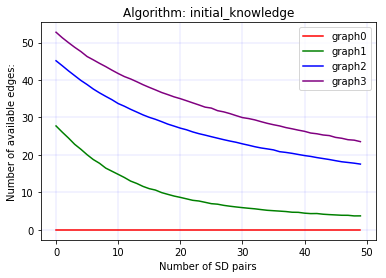

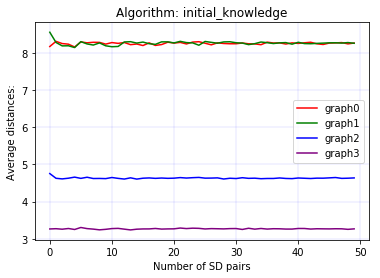

In [19]:
plot_results(initial_knowledge_results[0],'initial_knowledge')

In [25]:
print(global_knowledge_results)

[None, None]


In [ ]:
import routing_algorithms

for radius in range(0, 11):
    
    local_knowledge = []
    start = time.time()
    for i in range(1,3):
        arguments = { 'algorithm' : local_knowledge_algorithm,
                     'distance_threshold': 2**i, 'knowledge_radius': radius, 'graphs': det_graphs}
        
        local_knowledge += [routing_simulation.run_algorithm_for_graphs(Settings().number_of_source_destination_pairs,
                                                   Settings().number_of_samples, arguments)]
    end = time.time()
    plot_results(local_knowledge,'local_knowledge_' + str(radius))
    write_results_to_file(local_knowledge, 'local_knowledge_' + str(radius),
                          '' , (end - start))

In [12]:
power_law_graphs = ()

# Genearate on-demand graph:
graph_factory = GraphEdgesFactory(original_capacity = 0, distance_threshold = 1)
power_law_graph = graph_factory.generate_graph_edges(graph_factory.power_law_link)
power_law_graphs += (power_law_graph,)

for x in range(0, 3):
    graph_factory = GraphEdgesFactory(distance_threshold = 2 **x)
    power_law_graph = graph_factory.generate_graph_edges(graph_factory.power_law_link)
    power_law_graphs += (power_law_graph,)
print(power_law_graphs)

([(1, 2, 0), (2, 3, 0), (3, 4, 0), (4, 5, 0), (5, 6, 0), (6, 7, 0), (7, 8, 0), (8, 9, 0), (9, 10, 0), (10, 11, 0), (11, 12, 0), (12, 13, 0), (13, 14, 0), (14, 15, 0), (15, 16, 0), (16, 17, 0), (17, 18, 0), (18, 19, 0), (19, 20, 0), (20, 21, 0), (21, 22, 0), (22, 23, 0), (23, 24, 0), (24, 25, 0), (25, 26, 0), (26, 27, 0), (27, 28, 0), (28, 29, 0), (29, 30, 0), (30, 31, 0), (31, 32, 0), (32, 1, 0)], [(1, 2, 1), (2, 3, 2), (3, 4, 1), (4, 5, 3), (5, 6, 1), (6, 7, 1), (7, 8, 2), (8, 9, 1), (9, 10, 3), (10, 11, 1), (11, 12, 2), (12, 13, 1), (13, 14, 3), (14, 15, 1), (15, 16, 2), (16, 17, 1), (17, 18, 3), (18, 19, 1), (19, 20, 2), (20, 21, 2), (21, 22, 2), (22, 23, 1), (23, 24, 2), (24, 25, 2), (25, 26, 2), (26, 27, 1), (27, 28, 2), (28, 29, 1), (29, 30, 3), (30, 31, 1), (31, 32, 2), (32, 1, 3)], [(1, 2, 1), (2, 3, 1), (3, 4, 1), (4, 5, 1), (5, 6, 2), (6, 7, 1), (7, 8, 1), (8, 9, 3), (9, 10, 1), (10, 11, 1), (11, 12, 1), (12, 13, 1), (13, 14, 2), (14, 15, 1), (15, 16, 1), (16, 17, 1), (17, 18

In [15]:
print((end - start))

22.71350884437561


In [ ]:
### for radius in range(0, 16):
    start = time.time()
    local_knowledge_results = run_algorithm_for_graphs(deterministic_graphs(),
                                                   number_of_source_destination_pairs,
                                                   number_of_samples, local_knowledge_algorithm,
                                                   {'update_algorithm':update_local_knowledge,
                                                    'knowledge_radius': radius},
                                                   mean)
    end = time.time()
    plot_results(local_knowledge_results,'local_' + str(radius))
    write_results_to_file(local_knowledge_results, 'local_' +str(radius),'', (end - start))

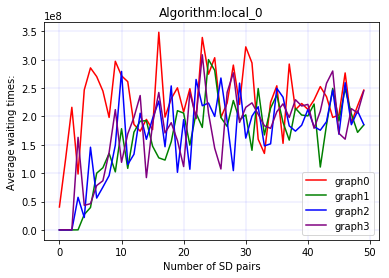

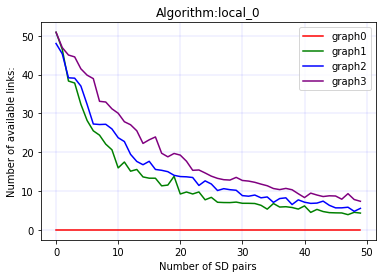

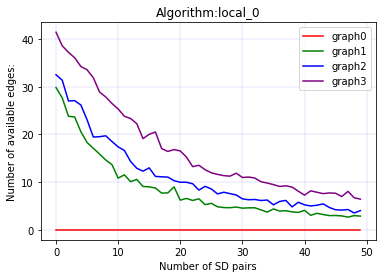

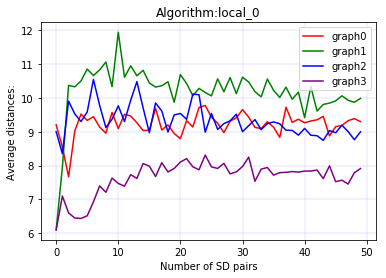

In [23]:
plot_results(local_knowledge_results,'local_' + str(radius))

In [14]:
#for radius in range(6, 11):
radius = 0
start = time.time()
power_law_graph = GraphEdgesFactory(distance_threshold=4)
local_knowledge_results = run_algorithm_for_graphs(deterministic_graphs(),
                                               Settings().number_of_source_destination_pairs,
                                               Settings().number_of_samples,
                                               local_knowledge_algorithm,
                                               {'update_algorithm':update_local_knowledge,
                                                'knowledge_radius': radius},
                                               mean)
end = time.time()
plot_results(local_knowledge_results,'local_' + str(radius))
write_results_to_file(local_knowledge_results, 'local_' +str(radius),'', (end - start))
print((end - start))

NameError: name 'deterministic_graphs' is not defined

In [8]:
sum([x[2]for x in deterministic_graphs()[3]])

56

In [ ]:
#for radius in range(6, 11):
radius = 0
start = time.time()
local_knowledge_results = run_algorithm_for_graphs(deterministic_graphs(),
                                               Settings().number_of_source_destination_pairs,
                                               Settings().number_of_samples,
                                               local_knowledge_algorithm,
                                               {'update_algorithm':update_local_knowledge,
                                                'knowledge_radius': radius},
                                               mean)
end = time.time()
plot_results(local_knowledge_results,'local_' + str(radius))
write_results_to_file(local_knowledge_results, 'local_' +str(radius),'', (end - start))
print((end - start))

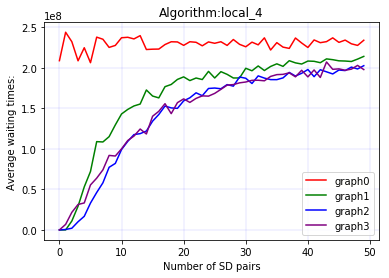

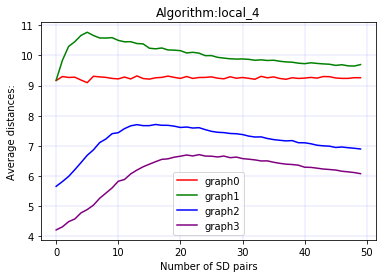

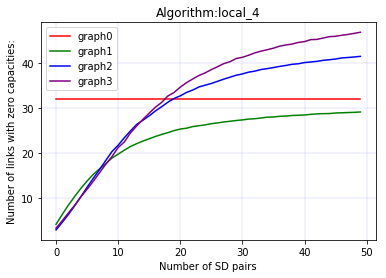

[([208955450.596, 244049936.488, 232337796.74, 208782151.57, 224916739.8471996, 206445900.96, 238008921.1582856, 235411368.43, 225330002.66266653, 227783185.42720023, 237252107.47381815, 237830192.074, 235818476.43630776, 239852470.8768571, 222731794.45359987, 223135890.6145, 223264815.24470577, 228863421.7633333, 232294703.12105274, 232083750.3916002, 227875448.3571429, 232316711.12036377, 231642510.5304351, 227292344.4805, 232099095.1844803, 230414373.69584626, 232318634.83599994, 227773648.78171426, 235070027.3067586, 229124739.14959955, 226109685.68451604, 231811933.78225, 228516019.5279998, 237117546.2951766, 222123482.73588595, 231200359.3936667, 225685725.61437818, 224104479.8721053, 236931980.81292325, 230758171.3827998, 225254166.86712208, 234533095.29571408, 231171984.40474385, 232452460.69218162, 237114742.4714664, 231529109.66017416, 234363118.53004247, 229785905.09175, 227804070.54375517, 234171339.1009603], [9.167, 9.2985, 9.26933333333334, 9.277, 9.182800000000002, 9.096

In [47]:
plot_results(local_knowledge_results,'local_' +str(radius))
#write_results_to_file(local_knowledge_results, 'local_' +str(radius),'', (end - start))
print(local_knowledge_results)

In [19]:
print((end - start))

1594.4323239326477


In [19]:
import matplotlib.pyplot as plt
import os
import time

results_graph1 = [[8.2373, 3211217.793, 12933650.206766646, 29921165.9525, 44544464.77674003, 69309856.076717, 83013518.60344297, 97188670.7842875, 111320613.89651103, 122187381.3724898, 131698654.16963589, 140337562.6642997, 144415225.3636311, 153594737.99897826, 156940074.15328664, 162007529.871875, 165463711.93497616, 168363229.00651732, 173826850.0713313, 176465092.200195, 182411133.00303844, 181148092.5426492, 183668812.7153391, 184908534.5554629, 187868382.15549204, 186705444.70801505, 190469822.56484434, 189357439.81208888, 192388164.60403112, 195341659.37213424, 195185066.60212225, 195904959.8853469, 198397570.5871053, 199116785.28465602, 200938227.95532274, 201400442.01211482, 202352183.20516968, 202445741.20754665, 203253332.92608958, 202561456.81779507, 205109247.33300275, 206302851.06476608, 204687262.91496944, 207700611.9773139, 207576803.93668887, 206685421.31101435, 205455716.9260837, 208418513.59861487, 209122216.3277244, 207989348.46610743],
    [8.295, 1610663.585, 10709066.616000006, 27231550.89025, 40381166.53560006, 68960497.97300006, 81039314.41928579, 105933335.158875, 114234782.68888874, 123492497.15669999, 128597198.2175453, 141161079.79775003, 136143312.69738463, 149839119.49214292, 150097250.25466663, 157286145.0511875, 168685366.62123567, 173531653.13105577, 176538781.84752628, 177420191.74199992, 168922902.83361885, 179692523.67368189, 184525070.9844784, 191213911.18745837, 187637734.12952018, 191391771.2711924, 189336668.13185215, 182805470.70157176, 198925394.26468968, 200540073.89013347, 196112318.1724192, 189220492.0325625, 197964803.5726059, 199345241.9991471, 204547944.12502852, 198527682.6128888, 205216008.51759487, 203272538.1801842, 194564412.60092315, 213504899.55454993, 208949658.39278054, 209185287.91878578, 204869444.46406993, 210669549.3338862, 205543370.6704887, 202389556.31932592, 210239850.2147449, 207739159.53087494, 208454189.88379586, 209583929.5522001],
           [8.218, 12.6535, 5134265.833333339, 18157540.7515, 41820259.1906, 59050098.79566669, 78717257.20528564, 100684550.232625, 105977499.67055556, 127391288.65940012, 127343961.44772716, 137486913.32399994, 151515709.05961552, 150838568.00657147, 154959220.47779995, 164803101.457125, 174019484.17588237, 167577407.90883353, 174819889.95268437, 180250680.76570007, 179600984.8307142, 192109141.22640914, 182987823.57386965, 189287288.26345816, 186676603.29088005, 177143517.72488442, 185189073.36692598, 185451433.01550004, 197388982.7787931, 194104693.66423357, 196773668.74374178, 204812855.113375, 198369827.163182, 198555944.30267632, 201754686.48160037, 202799032.89500013, 200122681.38894624, 203943693.52344725, 201430468.30758977, 201957789.93717495, 201607653.98631704, 198696501.14071447, 205477827.7205116, 201311905.49704564, 207262654.0048888, 208564321.96802187, 206139377.5363619, 207375119.20562482, 213100430.22000006, 207858814.53778017]]

results_graph2 = [[4.4467, 7033017.99955, 20738518.506033357, 36835792.01995, 49823780.21385993, 62591595.173650086, 81856825.46035732, 97921558.8029125, 105326370.03925596, 116443443.58504024, 124911345.66780955, 136200055.3644742, 142857937.13888434, 147472441.44745058, 152199836.158539, 158222020.775275, 164181152.7618886, 165666618.9964113, 168534918.40863612, 172161426.2279392, 174482888.3050805, 178271552.9814587, 181483108.97668302, 181154866.04966643, 182534566.05108377, 185304015.9476608, 184676085.69513777, 187497794.05580726, 191346843.21855196, 192249624.47661072, 192169736.15442005, 192783367.1469875, 194721845.96785125, 199829601.9114175, 197174445.63678217, 199375512.28895268, 199486523.49171948, 200460328.17515498, 199200359.4233083, 201875692.1489229, 201403525.6155727, 205312438.5561216, 204351542.06132445, 205070757.4335259, 206082120.87192184, 204425389.39416075, 205415326.0066654, 204089246.88969725, 208278096.19108304, 205773491.25959626],
    [4.655, 134268.7855, 7858191.982999998, 25736473.09975, 36882131.24439998, 50993023.15233331, 73405236.86514291, 86821057.737125, 86433629.95833339, 99193724.39220005, 115416614.73027278, 124702501.40800008, 139404886.23669213, 139011926.4342857, 147857449.44986674, 152766787.59275, 151722042.96205878, 162776847.43655536, 170629905.67642134, 166019659.1627498, 170162597.73047602, 165553275.81945425, 176447966.91956514, 178633339.42504176, 180892791.96420017, 180940133.20203823, 186103729.82518494, 185905528.99774992, 182007688.146862, 187241823.24046686, 184181451.6218709, 187470217.886, 192298591.76475757, 196432681.22338244, 195166091.89805713, 192262929.21208346, 201461959.10697338, 200944354.41021046, 200064003.45897433, 195786056.8949251, 200838999.5794874, 200614843.41592848, 206318989.68690684, 200931296.96250004, 202535538.80817762, 208244756.01152185, 204914299.0029362, 204013405.21660388, 202483698.75859198, 202759751.3800199],
           [4.59, 4.621, 4.997999999999998, 8.8175, 1007756.3574, 3340394.8794999993, 16248294.372571424, 30871036.5375, 43968198.20977781, 51686606.94519995, 72993647.4512727, 85688727.77783328, 96755186.55730772, 106610896.99478568, 111193768.40973352, 121261966.73075, 125235609.08252962, 129715252.97350004, 138307893.4897895, 132291394.91714995, 139673483.51409516, 144679564.68931818, 150299824.88013068, 155090415.59716657, 154709897.85912016, 161587337.50015426, 162725122.80155545, 162820811.5394643, 167144242.09044817, 172193076.3533999, 171859986.47741935, 175094523.61025, 177710150.92436358, 183371084.11694136, 184244772.8232571, 179367781.97386092, 180330382.77148667, 184236880.47160518, 186867968.84192288, 185817815.12884992, 190756592.0582928, 194106945.48597625, 182877211.6387906, 184426741.92206836, 194530721.3248444, 189452385.16428247, 190671074.57851058, 190091626.58122903, 194069864.2138368, 193976365.68984017]]

results_graph3 = [[3.2574, 19713397.98295, 44202358.74450014, 61044355.2238, 79776988.47024, 95140875.32783322, 109039928.00838588, 123145251.6359125, 125808681.22982219, 135210160.80133998, 148895438.33949986, 153142975.49325, 158598014.97811508, 161572488.33378562, 167185983.01128787, 168052059.99960625, 175616634.1293888, 179460640.43022245, 177372271.11210525, 180339081.4899509, 186007850.25575766, 184536438.22605377, 190164600.25623524, 191732601.43908715, 194660979.11162665, 193636824.36087748, 198920636.94603297, 196557403.03402087, 199468481.16966605, 198608801.17032045, 199059523.14859036, 201173937.4942594, 201533625.21928343, 202371292.9746389, 204155064.44426602, 205055673.53202856, 204073052.1647411, 205996614.01596227, 207279271.0013001, 206956127.25404748, 207564952.55028772, 208209193.66745168, 208693597.86557907, 208249484.69052032, 208514299.5344252, 209665610.39275196, 211313529.3106034, 211122376.53953573, 212226124.197215, 212753676.46201706],
    [3.257, 18120689.5725, 41233551.89966667, 56699086.987, 75040467.50400004, 89895681.70999998, 111027738.7370002, 116274407.63975, 126151792.6815558, 136440635.8807001, 150038771.95718208, 142086700.25424996, 152372260.6367692, 176788340.55299997, 169971645.97513354, 169846404.994, 181592320.5162352, 168090335.39950025, 183474193.6826318, 190101367.0350999, 188453890.67661905, 178514085.11568162, 184088147.41956493, 178121433.88983342, 193622283.69804037, 196844445.10473064, 193195321.8690371, 188305435.63071427, 200438295.70889604, 192538133.07413372, 201147292.57309672, 200994018.02534375, 207580886.41581824, 202617105.9353532, 200282237.5049713, 212422549.594528, 207317665.9167838, 201915435.75494757, 206283549.14251274, 209276602.7745002, 213344169.80978045, 208294821.28226212, 207485734.3446282, 206537850.8322272, 208247161.96811086, 206517438.0845216, 207320180.2689784, 210503739.3837082, 207521706.21687785, 213033823.82970005],
           [3.291, 3.3435, 3.5893333333333315, 4.6445, 121013.30280000008, 1473345.106833334, 7434779.007714283, 20664151.222625, 26695219.636222273, 46310192.404000014, 56369731.70536363, 70939643.38124986, 78143482.41769233, 96938098.92499997, 100922838.16153339, 109693434.2655, 124713367.8499412, 118971934.99666668, 123675337.86163154, 140339268.88575006, 140531920.52028587, 142291992.04263648, 154552718.9930871, 142267444.65170842, 150266691.8282398, 161714830.27538452, 153145058.87022215, 161355312.6503215, 162256399.74348262, 166602820.0632332, 162093093.09177426, 172747641.38965625, 170172711.87921217, 170222685.2344709, 175726723.8177428, 176352979.05547217, 187937249.65897325, 179627443.13386843, 184955466.5308975, 187798914.88852522, 185363368.95965865, 186428334.68290466, 186798369.10197684, 186235281.8569772, 182927734.75742215, 188824874.1460654, 190718422.35389367, 191632222.45170826, 193083545.780857, 193042935.6565]]

number_of_samples = 1000

In [5]:
colours = ['red', 'green', 'blue', 'c', 'grey', 'pink']
def plot_algorithm_comparison(data: list, titles: list, colours: list, name_of_measure: str, name_of_topology: str):
    for data_index in range(len(data)):
        plt.plot(data[data_index],color=colours[data_index], label=titles[data_index])
    plt.grid(color='b', linestyle='-', linewidth=0.1)

    plt.xlabel('Number of SD pairs')
    plt.ylabel(name_of_measure)
    plt.title(name_of_topology)
    plt.legend()

    timestr = time.strftime("%y_%m_%d__%H_%M")
    
    # Create the plots directory, if it is non-existant yet
    directory = 'plots/comp_alg'
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig('./'+ directory +'/comp' + name_of_topology + '_' + name_of_measure + str(number_of_samples) + '_' +'_' + timestr +'.png', bbox_inches='tight')
    plt.show()

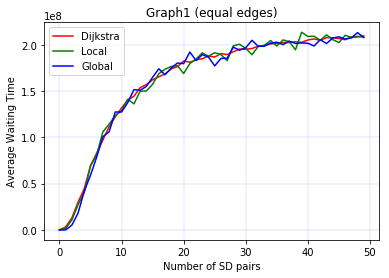

In [6]:
plot_algorithm_comparison(results_graph1, ['Dijkstra','Local', 'Global'], colours, 'Average Waiting Time', 'Graph1 (equal edges)')

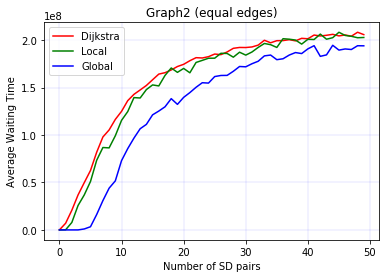

In [7]:
plot_algorithm_comparison(results_graph2, ['Dijkstra','Local', 'Global'], colours, 'Average Waiting Time', 'Graph2 (equal edges)')

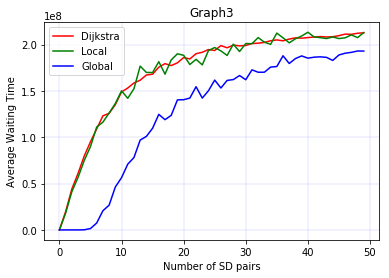

In [8]:
plot_algorithm_comparison(results_graph3, ['Dijkstra','Local', 'Global'], colours, 'Average Waiting Time', 'Graph3')

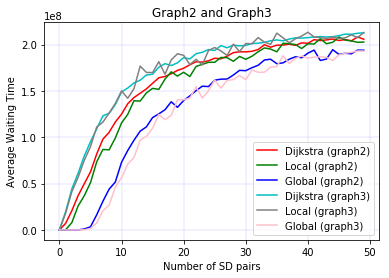

In [9]:
plot_algorithm_comparison(results_graph2 + results_graph3, ['Dijkstra (graph2)','Local (graph2)', 'Global (graph2)', 'Dijkstra (graph3)','Local (graph3)', 'Global (graph3)'], colours, 'Average Waiting Time', 'Graph2 and Graph3')